### Deep learning model training.
#### Top accuracy:
|model|miou|oa|update_time|    
|----|----|----|----|   
|U2Net|90.06%|94.0%|2026.2.16|    
|||||    




In [1]:
import time
import torch
import random
import pandas as pd
import torch.nn as nn
from glob import glob
from notebooks import config
import torch.nn.functional as F
from utils.imgShow import imsShow
import matplotlib.pyplot as plt
from torchvision.transforms import v2
from utils.data_aug import GaussianNoise
from utils.dataloader import read_scenes 
from utils.metrics import oa_binary, miou_binary
from utils.dataloader import SceneArraySet, PatchPathSet
from model import unet, u2net_att_2, u2net_dem_adj, unet_att
from model import deeplabv3plus, deeplabv3plus_mobilev2, u2net, u2net_att


In [2]:
patch_size = 512  ## patch size setting
patch_resize = None  ## patch resize setting
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
print(f'train scenes: {len(paths_scene_tra)}')
## valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}/*'))  ## for model prediction 
print(f'vali patch {patch_size}: {len(paths_valset)}')


train scenes: 52
vali patch 512: 117


### dataset loading

In [3]:
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra) 


In [4]:
transforms_tra = v2.Compose([
            v2.ToImage(),
            v2.RandomCrop(size=(patch_size, patch_size)),
            v2.RandomHorizontalFlip(p=0.3),
            v2.RandomVerticalFlip(p=0.3),
            v2.RandomRotation(degrees=180),
            GaussianNoise(mean = 0.0, sigma_max_img=0.1, sigma_max_dem=0, p=0.3) 
        ]) 

transforms_val = v2.Compose([
      v2.ToDtype(torch.float32),
       ])  


In [5]:
# Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                          truths_arr=truths_arr, 
                          patch_size=patch_size,
                          transforms=transforms_tra)
val_data = PatchPathSet(paths_valset=paths_valset, transforms=transforms_val)

## Create data loaders
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=5)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4, 
                                         num_workers=5)


#### Model training

In [6]:
### check model
# model = unet(num_bands=7)
# model = u2net(num_bands_b1=6, num_bands_b2=1)
model = u2net_att_2(num_bands_b1=6, num_bands_b2=1)
# model = deeplabv3plus(num_bands=7)
# model = deeplabv3plus_mobilev2(num_bands=7)


In [7]:
input_tensor = torch.randn(2, 7, 512, 512) 
latitude = torch.randn(2)   # batch size of 2, 1 latitude value per sample  
output = model(input_tensor)  
print(output.shape) 


torch.Size([2, 1, 512, 512])


In [8]:
### create loss and optimizer
loss_bce = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                                      mode='min', 
                                      factor=0.5, 
                                      patience=20,
                                      min_lr=1e-5)


In [9]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, 
                x, y, 
                patch_size):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        if patch_size > 256:  ### crop inner 256x256 for evaluation
            pred = v2.functional.center_crop(pred, 256)
            y = v2.functional.center_crop(y, 256)
        loss = loss_fn(pred, y)
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, 
                    optimizer, 
                    tra_loader, 
                    val_loader,                     
                    epoches, 
                    device, 
                    patch_size, 
                    lr_scheduler=None):
    tra_loss_loops, tra_miou_loops, tra_oa_loops = [], [], []
    val_loss_loops, val_miou_loops, val_oa_loops = [], [], []
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                            optimizer=optimizer, 
                                            x=x_batch, 
                                            y=y_batch, 
                                            )
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        if lr_scheduler:
          lr_scheduler.step(tra_loss)    ## if using ReduceLROnPlateau
        '''----- validation the model: time consuming -----'''
        if (epoch+1) % 3 == 0: 
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                loss, miou, oa = val_step(model=model, 
                                            loss_fn=loss_fn, 
                                            x=x_batch, 
                                            y=y_batch, 
                                            patch_size=patch_size,
                                            )
                val_loss += loss.item()
                val_miou += miou.item()
                val_oa += oa.item()
            tra_loss = tra_loss/size_tra_loader
            tra_miou = tra_miou/size_tra_loader
            tra_oa = tra_oa/size_tra_loader
            val_loss = val_loss/size_val_loader
            val_miou = val_miou/size_val_loader
            val_oa = val_oa/size_val_loader
            tra_loss_loops.append(tra_loss); tra_miou_loops.append(tra_miou); tra_oa_loops.append(tra_oa)
            val_loss_loops.append(val_loss); val_miou_loops.append(val_miou); val_oa_loops.append(val_oa)
            print(f'Ep{epoch}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, '
                    f'val-> Loss:{val_loss:.3f},Oa:{val_oa:.3f}, Miou:{val_miou:.3f},time:{time.time()-start:.1f}s')
        else: 
            tra_loss = tra_loss/size_tra_loader
            tra_miou = tra_miou/size_tra_loader
            tra_oa = tra_oa/size_tra_loader
            print(f'Ep{epoch}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, \
                                time:{time.time()-start:.1f}s')

        ## show the result
        if (epoch+1)%20 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = patch.unsqueeze(0).to(device), truth.to(device)
            pred = model(patch)
            if patch_size > 256:
                pred_val = v2.functional.center_crop(pred, 256)
                patch_val = v2.functional.center_crop(patch, 256)
                truth_val = v2.functional.center_crop(truth, 256)
            else:
                patch_val = patch
                pred_val = pred
                truth_val = truth
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)            
            pred = pred[0].to('cpu').detach().numpy()
            patch_val = patch_val[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred_val = pred_val[0].to('cpu').detach().numpy()
            truth_val = truth_val.to('cpu').detach().numpy()
            imsShow([patch, pred, patch_val, pred_val, truth_val], 
                    clip_list = (2,0,2,0,0),
                    img_name_list=['input_patch', 'pred', 'patch_val', 'pred_val', 'truth_val'],                     
                    figsize=(15, 3))
            plt.tight_layout() 
    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'tra_oa': tra_oa_loops, 
                'val_loss': val_loss_loops, 'val_miou': val_miou_loops, 'val_oa': val_oa_loops}
    return metrics 


Ep0: tra-> Loss:0.250,Oa:0.890,Miou:0.814,                                 time:2.7s
Ep1: tra-> Loss:0.192,Oa:0.899,Miou:0.841,                                 time:2.5s
Ep2: tra-> Loss:0.142,Oa:0.889,Miou:0.837, val-> Loss:0.135,Oa:0.893, Miou:0.769,time:4.3s
Ep3: tra-> Loss:0.100,Oa:0.945,Miou:0.874,                                 time:2.4s
Ep4: tra-> Loss:0.075,Oa:0.962,Miou:0.924,                                 time:2.5s
Ep5: tra-> Loss:0.075,Oa:0.959,Miou:0.904, val-> Loss:0.074,Oa:0.925, Miou:0.858,time:4.4s
Ep6: tra-> Loss:0.081,Oa:0.952,Miou:0.860,                                 time:2.3s
Ep7: tra-> Loss:0.070,Oa:0.937,Miou:0.907,                                 time:2.5s
Ep8: tra-> Loss:0.069,Oa:0.944,Miou:0.854, val-> Loss:0.071,Oa:0.912, Miou:0.868,time:4.3s
Ep9: tra-> Loss:0.058,Oa:0.905,Miou:0.856,                                 time:2.6s
Ep10: tra-> Loss:0.059,Oa:0.971,Miou:0.930,                                 time:2.3s
Ep11: tra-> Loss:0.090,Oa:0.930,Miou:0.878, va

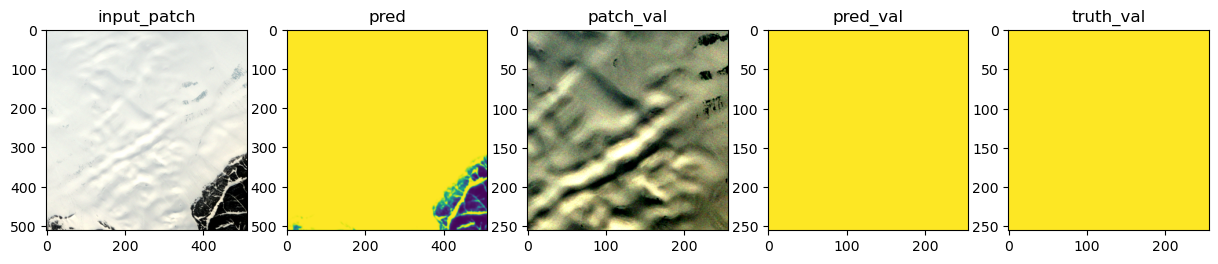

Ep20: tra-> Loss:0.057,Oa:0.977,Miou:0.935, val-> Loss:0.081,Oa:0.889, Miou:0.838,time:4.4s
Ep21: tra-> Loss:0.064,Oa:0.949,Miou:0.904,                                 time:2.5s
Ep22: tra-> Loss:0.059,Oa:0.967,Miou:0.918,                                 time:2.5s
Ep23: tra-> Loss:0.067,Oa:0.957,Miou:0.913, val-> Loss:0.072,Oa:0.931, Miou:0.866,time:4.3s
Ep24: tra-> Loss:0.046,Oa:0.978,Miou:0.935,                                 time:2.4s
Ep25: tra-> Loss:0.047,Oa:0.949,Miou:0.896,                                 time:2.5s
Ep26: tra-> Loss:0.048,Oa:0.948,Miou:0.909, val-> Loss:0.056,Oa:0.930, Miou:0.883,time:4.4s
Ep27: tra-> Loss:0.053,Oa:0.967,Miou:0.919,                                 time:2.5s
Ep28: tra-> Loss:0.036,Oa:0.980,Miou:0.948,                                 time:2.4s
Ep29: tra-> Loss:0.045,Oa:0.953,Miou:0.928, val-> Loss:0.059,Oa:0.931, Miou:0.878,time:4.4s
Ep30: tra-> Loss:0.065,Oa:0.929,Miou:0.881,                                 time:2.2s
Ep31: tra-> Loss:0.051,Oa:0.97

<Figure size 640x480 with 0 Axes>

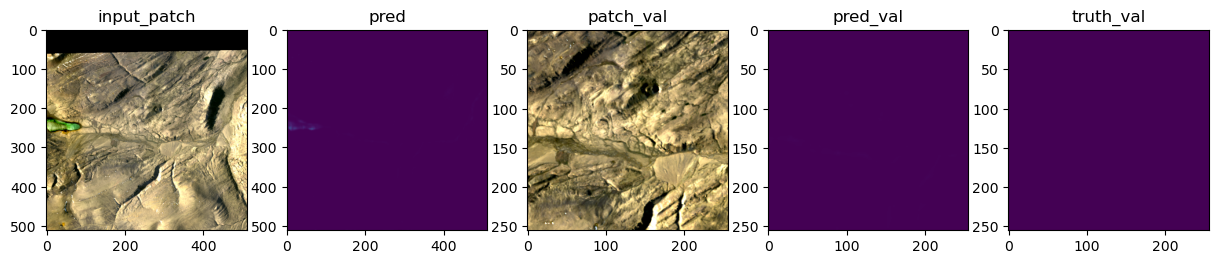

Ep40: tra-> Loss:0.041,Oa:0.961,Miou:0.931,                                 time:2.7s
Ep41: tra-> Loss:0.063,Oa:0.955,Miou:0.900, val-> Loss:0.058,Oa:0.930, Miou:0.883,time:4.2s
Ep42: tra-> Loss:0.076,Oa:0.958,Miou:0.906,                                 time:2.4s
Ep43: tra-> Loss:0.034,Oa:0.938,Miou:0.917,                                 time:2.4s
Ep44: tra-> Loss:0.041,Oa:0.974,Miou:0.956, val-> Loss:0.059,Oa:0.918, Miou:0.877,time:4.3s
Ep45: tra-> Loss:0.046,Oa:0.937,Miou:0.868,                                 time:2.4s
Ep46: tra-> Loss:0.038,Oa:0.975,Miou:0.952,                                 time:2.5s
Ep47: tra-> Loss:0.045,Oa:0.979,Miou:0.950, val-> Loss:0.054,Oa:0.920, Miou:0.887,time:4.6s
Ep48: tra-> Loss:0.045,Oa:0.966,Miou:0.947,                                 time:2.6s
Ep49: tra-> Loss:0.042,Oa:0.972,Miou:0.927,                                 time:2.7s
Ep50: tra-> Loss:0.025,Oa:0.975,Miou:0.938, val-> Loss:0.049,Oa:0.927, Miou:0.887,time:4.3s
Ep51: tra-> Loss:0.036,Oa:0.98

<Figure size 640x480 with 0 Axes>

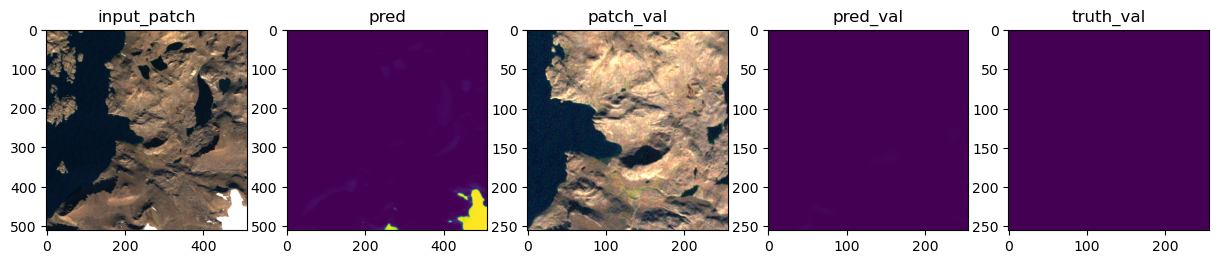

Ep60: tra-> Loss:0.058,Oa:0.945,Miou:0.908,                                 time:2.5s
Ep61: tra-> Loss:0.056,Oa:0.941,Miou:0.913,                                 time:2.3s
Ep62: tra-> Loss:0.043,Oa:0.964,Miou:0.923, val-> Loss:0.055,Oa:0.917, Miou:0.886,time:4.4s
Ep63: tra-> Loss:0.035,Oa:0.974,Miou:0.937,                                 time:2.4s
Ep64: tra-> Loss:0.037,Oa:0.982,Miou:0.952,                                 time:2.5s
Ep65: tra-> Loss:0.034,Oa:0.915,Miou:0.888, val-> Loss:0.048,Oa:0.930, Miou:0.889,time:4.4s
Ep66: tra-> Loss:0.036,Oa:0.978,Miou:0.902,                                 time:2.3s
Ep67: tra-> Loss:0.055,Oa:0.974,Miou:0.941,                                 time:2.8s
Ep68: tra-> Loss:0.031,Oa:0.961,Miou:0.930, val-> Loss:0.046,Oa:0.930, Miou:0.890,time:4.3s
Ep69: tra-> Loss:0.041,Oa:0.975,Miou:0.943,                                 time:2.6s
Ep70: tra-> Loss:0.034,Oa:0.941,Miou:0.915,                                 time:2.6s
Ep71: tra-> Loss:0.036,Oa:0.966,Miou

<Figure size 640x480 with 0 Axes>

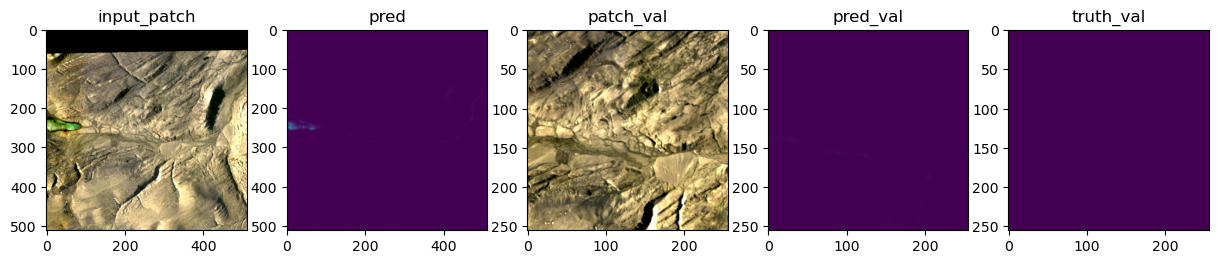

Ep80: tra-> Loss:0.085,Oa:0.967,Miou:0.940, val-> Loss:0.078,Oa:0.894, Miou:0.849,time:4.4s
Ep81: tra-> Loss:0.043,Oa:0.968,Miou:0.944,                                 time:2.3s
Ep82: tra-> Loss:0.044,Oa:0.968,Miou:0.944,                                 time:2.3s
Ep83: tra-> Loss:0.036,Oa:0.972,Miou:0.946, val-> Loss:0.049,Oa:0.923, Miou:0.892,time:4.6s
Ep84: tra-> Loss:0.033,Oa:0.980,Miou:0.937,                                 time:2.4s
Ep85: tra-> Loss:0.036,Oa:0.971,Miou:0.940,                                 time:2.4s
Ep86: tra-> Loss:0.024,Oa:0.985,Miou:0.958, val-> Loss:0.046,Oa:0.930, Miou:0.891,time:4.2s
Ep87: tra-> Loss:0.033,Oa:0.982,Miou:0.962,                                 time:2.4s
Ep88: tra-> Loss:0.029,Oa:0.982,Miou:0.960,                                 time:2.5s
Ep89: tra-> Loss:0.033,Oa:0.973,Miou:0.953, val-> Loss:0.044,Oa:0.931, Miou:0.892,time:4.3s
Ep90: tra-> Loss:0.030,Oa:0.979,Miou:0.957,                                 time:2.3s
Ep91: tra-> Loss:0.035,Oa:0.97

<Figure size 640x480 with 0 Axes>

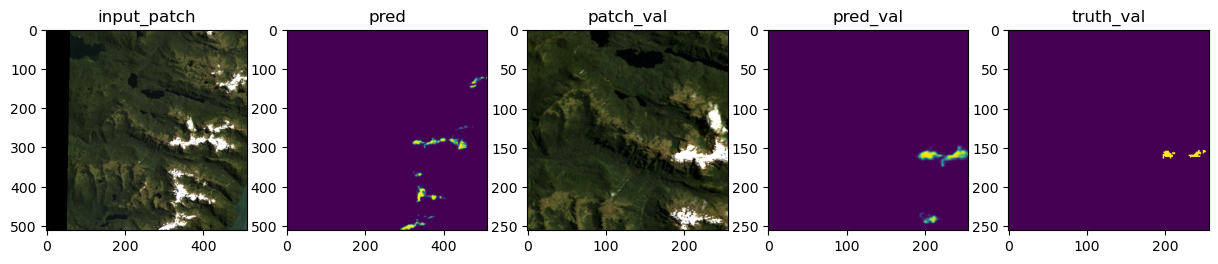

Ep100: tra-> Loss:0.035,Oa:0.977,Miou:0.959,                                 time:2.6s
Ep101: tra-> Loss:0.030,Oa:0.977,Miou:0.962, val-> Loss:0.049,Oa:0.923, Miou:0.888,time:4.5s
Ep102: tra-> Loss:0.026,Oa:0.974,Miou:0.928,                                 time:2.4s
Ep103: tra-> Loss:0.032,Oa:0.971,Miou:0.923,                                 time:2.5s
Ep104: tra-> Loss:0.035,Oa:0.982,Miou:0.958, val-> Loss:0.044,Oa:0.923, Miou:0.893,time:4.3s
Ep105: tra-> Loss:0.029,Oa:0.975,Miou:0.954,                                 time:2.6s
Ep106: tra-> Loss:0.030,Oa:0.972,Miou:0.951,                                 time:2.3s
Ep107: tra-> Loss:0.023,Oa:0.981,Miou:0.940, val-> Loss:0.067,Oa:0.902, Miou:0.865,time:4.3s
Ep108: tra-> Loss:0.035,Oa:0.974,Miou:0.944,                                 time:2.4s
Ep109: tra-> Loss:0.066,Oa:0.967,Miou:0.933,                                 time:2.5s
Ep110: tra-> Loss:0.045,Oa:0.965,Miou:0.925, val-> Loss:0.053,Oa:0.920, Miou:0.888,time:4.2s
Ep111: tra-> Loss:0

<Figure size 640x480 with 0 Axes>

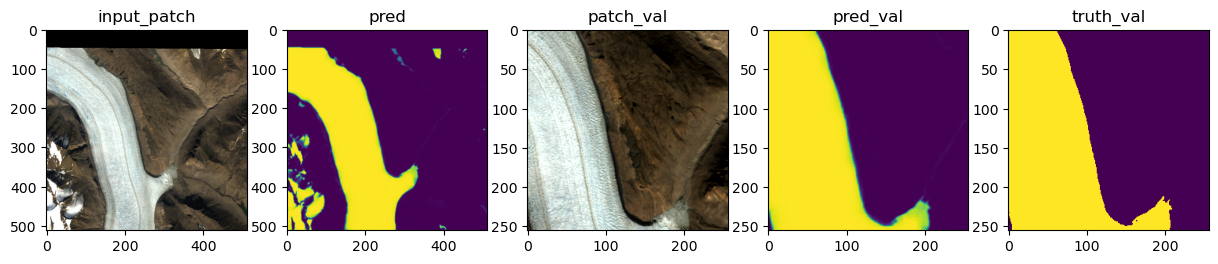

Ep120: tra-> Loss:0.036,Oa:0.982,Miou:0.963,                                 time:2.5s
Ep121: tra-> Loss:0.035,Oa:0.969,Miou:0.946,                                 time:2.4s
Ep122: tra-> Loss:0.020,Oa:0.978,Miou:0.954, val-> Loss:0.044,Oa:0.928, Miou:0.896,time:4.3s
Ep123: tra-> Loss:0.027,Oa:0.936,Miou:0.919,                                 time:2.2s
Ep124: tra-> Loss:0.033,Oa:0.978,Miou:0.926,                                 time:2.5s
Ep125: tra-> Loss:0.030,Oa:0.969,Miou:0.937, val-> Loss:0.044,Oa:0.926, Miou:0.895,time:4.3s
Ep126: tra-> Loss:0.044,Oa:0.971,Miou:0.951,                                 time:2.5s
Ep127: tra-> Loss:0.054,Oa:0.949,Miou:0.893,                                 time:2.4s
Ep128: tra-> Loss:0.060,Oa:0.959,Miou:0.930, val-> Loss:0.073,Oa:0.894, Miou:0.847,time:4.2s
Ep129: tra-> Loss:0.043,Oa:0.971,Miou:0.929,                                 time:2.5s
Ep130: tra-> Loss:0.047,Oa:0.980,Miou:0.948,                                 time:2.4s
Ep131: tra-> Loss:0.032,O

<Figure size 640x480 with 0 Axes>

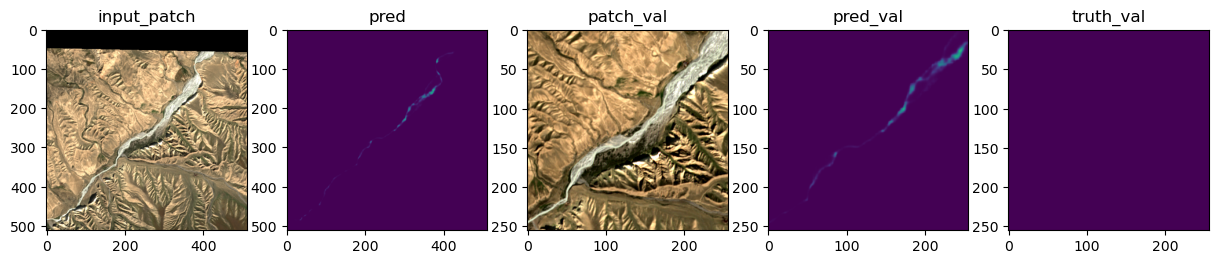

Ep140: tra-> Loss:0.037,Oa:0.976,Miou:0.954, val-> Loss:0.046,Oa:0.924, Miou:0.893,time:4.2s
Ep141: tra-> Loss:0.031,Oa:0.970,Miou:0.948,                                 time:2.5s
Ep142: tra-> Loss:0.036,Oa:0.978,Miou:0.956,                                 time:2.4s
Ep143: tra-> Loss:0.030,Oa:0.978,Miou:0.955, val-> Loss:0.047,Oa:0.923, Miou:0.892,time:4.2s
Ep144: tra-> Loss:0.040,Oa:0.977,Miou:0.960,                                 time:2.4s
Ep145: tra-> Loss:0.034,Oa:0.977,Miou:0.930,                                 time:2.3s
Ep146: tra-> Loss:0.035,Oa:0.972,Miou:0.950, val-> Loss:0.045,Oa:0.926, Miou:0.892,time:4.4s
Ep147: tra-> Loss:0.034,Oa:0.974,Miou:0.958,                                 time:2.6s
Ep148: tra-> Loss:0.046,Oa:0.967,Miou:0.945,                                 time:2.4s
Ep149: tra-> Loss:0.034,Oa:0.968,Miou:0.945, val-> Loss:0.046,Oa:0.925, Miou:0.891,time:4.5s
Ep150: tra-> Loss:0.031,Oa:0.977,Miou:0.934,                                 time:2.5s
Ep151: tra-> Loss:0

<Figure size 640x480 with 0 Axes>

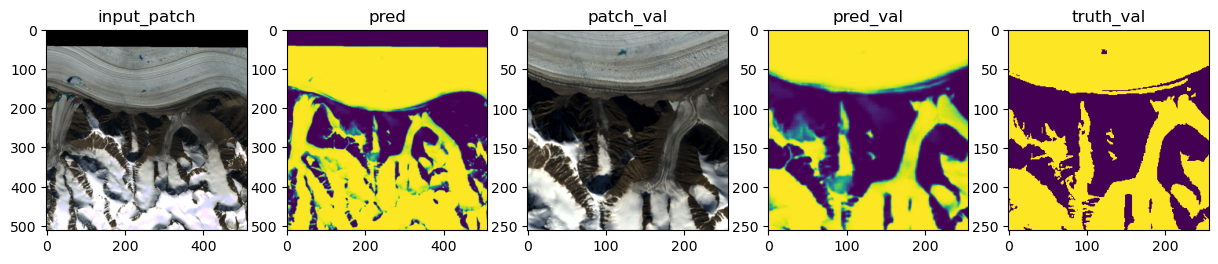

Ep160: tra-> Loss:0.032,Oa:0.980,Miou:0.958,                                 time:2.4s
Ep161: tra-> Loss:0.025,Oa:0.967,Miou:0.922, val-> Loss:0.045,Oa:0.929, Miou:0.891,time:4.5s
Ep162: tra-> Loss:0.032,Oa:0.975,Miou:0.939,                                 time:2.5s
Ep163: tra-> Loss:0.028,Oa:0.982,Miou:0.966,                                 time:2.4s
Ep164: tra-> Loss:0.034,Oa:0.959,Miou:0.942, val-> Loss:0.043,Oa:0.928, Miou:0.894,time:4.2s
Ep165: tra-> Loss:0.026,Oa:0.980,Miou:0.934,                                 time:2.5s
Ep166: tra-> Loss:0.032,Oa:0.982,Miou:0.951,                                 time:2.5s
Ep167: tra-> Loss:0.027,Oa:0.984,Miou:0.963, val-> Loss:0.043,Oa:0.927, Miou:0.894,time:4.5s
Ep168: tra-> Loss:0.024,Oa:0.981,Miou:0.962,                                 time:2.5s
Ep169: tra-> Loss:0.026,Oa:0.963,Miou:0.946,                                 time:2.4s
Ep170: tra-> Loss:0.030,Oa:0.947,Miou:0.927, val-> Loss:0.043,Oa:0.926, Miou:0.894,time:4.4s
Ep171: tra-> Loss:0

<Figure size 640x480 with 0 Axes>

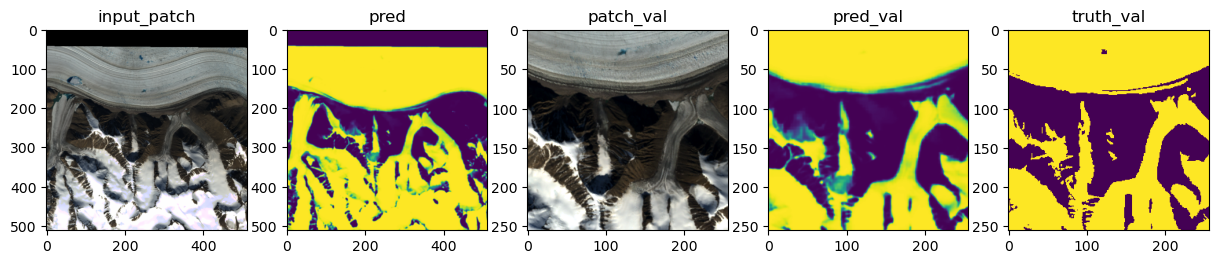

Ep180: tra-> Loss:0.037,Oa:0.948,Miou:0.927,                                 time:2.3s
Ep181: tra-> Loss:0.027,Oa:0.983,Miou:0.969,                                 time:2.4s
Ep182: tra-> Loss:0.032,Oa:0.968,Miou:0.946, val-> Loss:0.043,Oa:0.929, Miou:0.894,time:4.5s
Ep183: tra-> Loss:0.030,Oa:0.972,Miou:0.943,                                 time:2.3s
Ep184: tra-> Loss:0.021,Oa:0.975,Miou:0.947,                                 time:2.4s
Ep185: tra-> Loss:0.031,Oa:0.973,Miou:0.951, val-> Loss:0.043,Oa:0.925, Miou:0.895,time:4.4s
Ep186: tra-> Loss:0.031,Oa:0.976,Miou:0.957,                                 time:2.5s
Ep187: tra-> Loss:0.026,Oa:0.979,Miou:0.966,                                 time:2.6s
Ep188: tra-> Loss:0.032,Oa:0.979,Miou:0.964, val-> Loss:0.043,Oa:0.926, Miou:0.895,time:4.3s
Ep189: tra-> Loss:0.029,Oa:0.977,Miou:0.957,                                 time:2.5s
Ep190: tra-> Loss:0.031,Oa:0.981,Miou:0.963,                                 time:2.5s
Ep191: tra-> Loss:0.029,O

<Figure size 640x480 with 0 Axes>

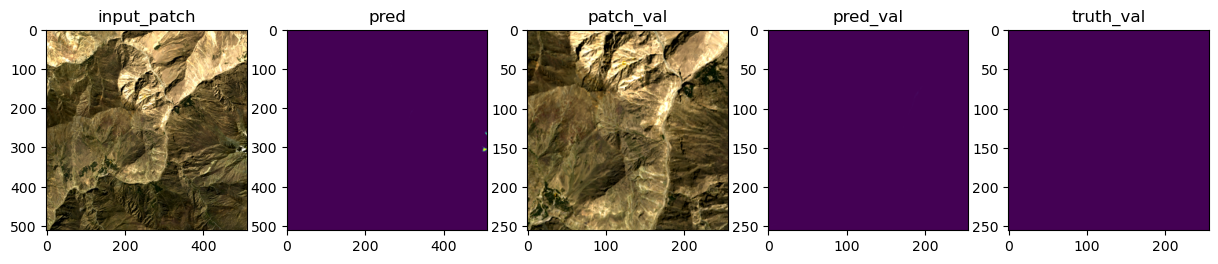

Ep200: tra-> Loss:0.026,Oa:0.971,Miou:0.948, val-> Loss:0.043,Oa:0.926, Miou:0.895,time:4.2s
Ep201: tra-> Loss:0.031,Oa:0.978,Miou:0.953,                                 time:2.3s
Ep202: tra-> Loss:0.035,Oa:0.981,Miou:0.959,                                 time:2.4s
Ep203: tra-> Loss:0.023,Oa:0.981,Miou:0.960, val-> Loss:0.043,Oa:0.925, Miou:0.895,time:4.5s
Ep204: tra-> Loss:0.031,Oa:0.976,Miou:0.958,                                 time:2.8s
Ep205: tra-> Loss:0.027,Oa:0.979,Miou:0.962,                                 time:2.5s
Ep206: tra-> Loss:0.026,Oa:0.976,Miou:0.959, val-> Loss:0.043,Oa:0.925, Miou:0.895,time:4.2s
Ep207: tra-> Loss:0.025,Oa:0.967,Miou:0.941,                                 time:2.5s
Ep208: tra-> Loss:0.028,Oa:0.984,Miou:0.969,                                 time:2.2s
Ep209: tra-> Loss:0.032,Oa:0.973,Miou:0.953, val-> Loss:0.043,Oa:0.925, Miou:0.895,time:4.4s
Ep210: tra-> Loss:0.029,Oa:0.962,Miou:0.936,                                 time:2.5s
Ep211: tra-> Loss:0

<Figure size 640x480 with 0 Axes>

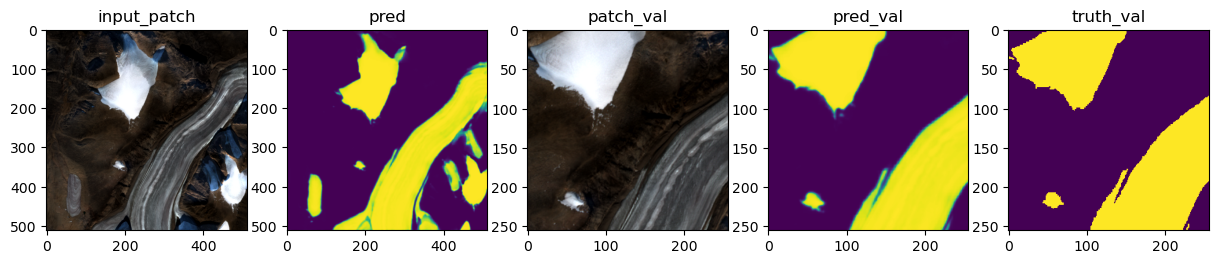

Ep220: tra-> Loss:0.024,Oa:0.980,Miou:0.958,                                 time:2.3s
Ep221: tra-> Loss:0.027,Oa:0.977,Miou:0.959, val-> Loss:0.042,Oa:0.925, Miou:0.895,time:4.4s
Ep222: tra-> Loss:0.027,Oa:0.980,Miou:0.957,                                 time:2.6s
Ep223: tra-> Loss:0.024,Oa:0.980,Miou:0.963,                                 time:2.5s
Ep224: tra-> Loss:0.024,Oa:0.979,Miou:0.961, val-> Loss:0.042,Oa:0.926, Miou:0.895,time:4.2s
Ep225: tra-> Loss:0.023,Oa:0.973,Miou:0.951,                                 time:2.5s
Ep226: tra-> Loss:0.021,Oa:0.978,Miou:0.959,                                 time:2.5s
Ep227: tra-> Loss:0.032,Oa:0.977,Miou:0.955, val-> Loss:0.042,Oa:0.927, Miou:0.895,time:4.6s
Ep228: tra-> Loss:0.026,Oa:0.973,Miou:0.951,                                 time:2.3s
Ep229: tra-> Loss:0.028,Oa:0.976,Miou:0.954,                                 time:2.4s
Ep230: tra-> Loss:0.027,Oa:0.974,Miou:0.952, val-> Loss:0.042,Oa:0.926, Miou:0.895,time:4.5s
Ep231: tra-> Loss:0

<Figure size 640x480 with 0 Axes>

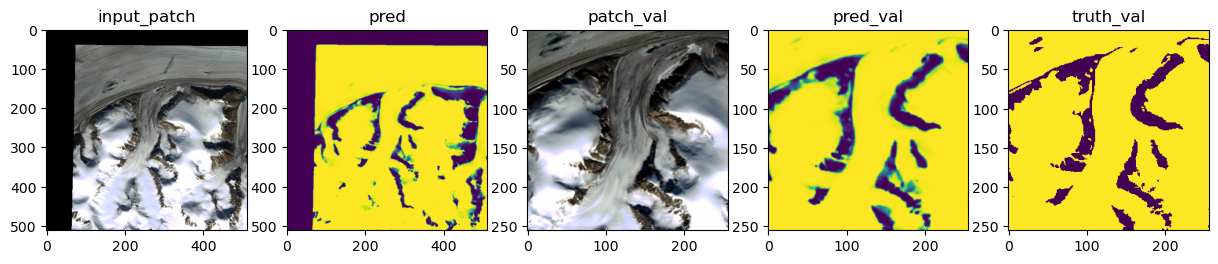

Ep240: tra-> Loss:0.033,Oa:0.978,Miou:0.961,                                 time:2.5s
Ep241: tra-> Loss:0.026,Oa:0.979,Miou:0.963,                                 time:2.5s
Ep242: tra-> Loss:0.031,Oa:0.943,Miou:0.926, val-> Loss:0.042,Oa:0.925, Miou:0.895,time:4.2s
Ep243: tra-> Loss:0.033,Oa:0.964,Miou:0.921,                                 time:2.5s
Ep244: tra-> Loss:0.023,Oa:0.970,Miou:0.954,                                 time:2.5s
Ep245: tra-> Loss:0.029,Oa:0.973,Miou:0.955, val-> Loss:0.044,Oa:0.924, Miou:0.894,time:4.3s
Ep246: tra-> Loss:0.034,Oa:0.982,Miou:0.954,                                 time:2.4s
Ep247: tra-> Loss:0.031,Oa:0.974,Miou:0.948,                                 time:2.5s
Ep248: tra-> Loss:0.029,Oa:0.980,Miou:0.958, val-> Loss:0.043,Oa:0.924, Miou:0.895,time:4.5s
Ep249: tra-> Loss:0.029,Oa:0.984,Miou:0.967,                                 time:2.5s
Ep250: tra-> Loss:0.029,Oa:0.983,Miou:0.968,                                 time:2.5s
Ep251: tra-> Loss:0.030,O

<Figure size 640x480 with 0 Axes>

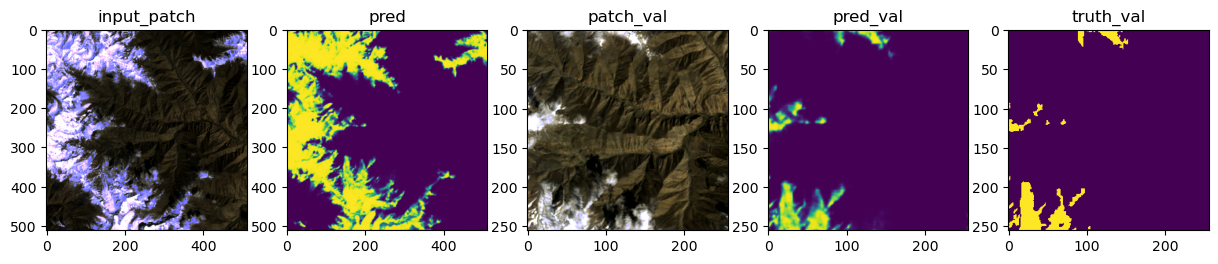

Ep260: tra-> Loss:0.027,Oa:0.973,Miou:0.952, val-> Loss:0.042,Oa:0.925, Miou:0.895,time:4.5s
Ep261: tra-> Loss:0.029,Oa:0.983,Miou:0.964,                                 time:2.3s
Ep262: tra-> Loss:0.030,Oa:0.975,Miou:0.945,                                 time:2.4s
Ep263: tra-> Loss:0.028,Oa:0.976,Miou:0.953, val-> Loss:0.042,Oa:0.925, Miou:0.895,time:4.2s
Ep264: tra-> Loss:0.030,Oa:0.977,Miou:0.949,                                 time:2.5s
Ep265: tra-> Loss:0.027,Oa:0.983,Miou:0.964,                                 time:2.5s
Ep266: tra-> Loss:0.033,Oa:0.971,Miou:0.944, val-> Loss:0.042,Oa:0.925, Miou:0.895,time:4.6s
Ep267: tra-> Loss:0.028,Oa:0.962,Miou:0.937,                                 time:2.5s
Ep268: tra-> Loss:0.037,Oa:0.971,Miou:0.942,                                 time:2.5s
Ep269: tra-> Loss:0.024,Oa:0.966,Miou:0.948, val-> Loss:0.043,Oa:0.925, Miou:0.895,time:4.3s
Ep270: tra-> Loss:0.025,Oa:0.983,Miou:0.944,                                 time:2.4s
Ep271: tra-> Loss:0

<Figure size 640x480 with 0 Axes>

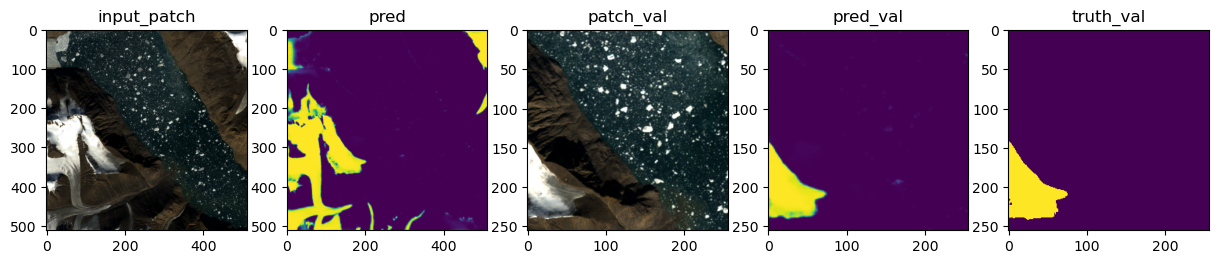

Ep280: tra-> Loss:0.035,Oa:0.973,Miou:0.947,                                 time:2.2s
Ep281: tra-> Loss:0.022,Oa:0.980,Miou:0.955, val-> Loss:0.043,Oa:0.924, Miou:0.895,time:4.4s
Ep282: tra-> Loss:0.020,Oa:0.982,Miou:0.966,                                 time:2.3s
Ep283: tra-> Loss:0.028,Oa:0.981,Miou:0.956,                                 time:2.3s
Ep284: tra-> Loss:0.031,Oa:0.953,Miou:0.927, val-> Loss:0.043,Oa:0.924, Miou:0.895,time:4.6s
Ep285: tra-> Loss:0.022,Oa:0.978,Miou:0.958,                                 time:2.4s
Ep286: tra-> Loss:0.031,Oa:0.950,Miou:0.931,                                 time:2.4s
Ep287: tra-> Loss:0.025,Oa:0.971,Miou:0.945, val-> Loss:0.043,Oa:0.925, Miou:0.895,time:4.3s
Ep288: tra-> Loss:0.026,Oa:0.981,Miou:0.962,                                 time:2.4s
Ep289: tra-> Loss:0.029,Oa:0.971,Miou:0.952,                                 time:2.3s
Ep290: tra-> Loss:0.025,Oa:0.983,Miou:0.960, val-> Loss:0.042,Oa:0.924, Miou:0.895,time:4.4s
Ep291: tra-> Loss:0

<Figure size 640x480 with 0 Axes>

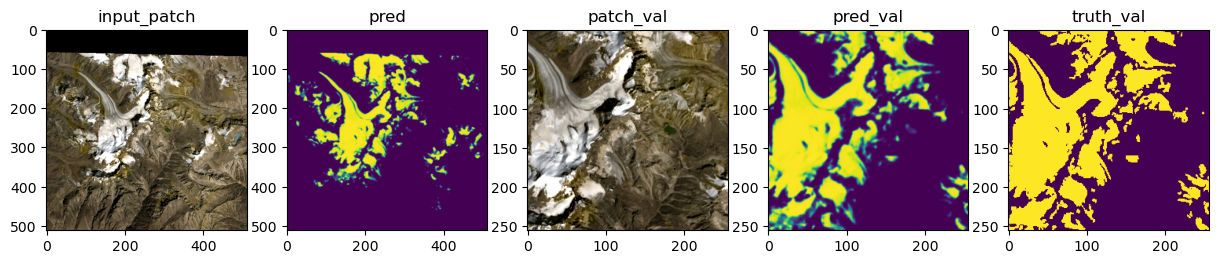

<Figure size 640x480 with 0 Axes>

In [10]:
device = torch.device('cuda:0') 
metrics = train_loops(model=model, 
                epoches=300,  
                loss_fn=loss_bce,  
                optimizer=optimizer,  
                tra_loader=tra_loader,  
                val_loader=val_loader,  
                patch_size=patch_size,  
                lr_scheduler=lr_scheduler,  
                device=device)  


In [11]:
# model saving 
# model_name = 'unet' 
# model_name = 'u2net' 
model_name = 'u2net_att' 
# model_name = 'deeplabv3plus'  
# model_name = 'deeplabv3plus_mb2' 
# path_save = f'model/trained/patch_{patch_size}/{model_name}_weights_1.pth'
path_save = f'model/trained/seg_models/{model_name}_weights_1.pth'
torch.save(model.state_dict(), path_save)     ## save weights of the trained model 
## model.load_state_dict(torch.load(path_save, weights_only=True))  ## load the weights of the trained model
## metrics saving
path_metrics = f'model/trained/seg_models/{model_name}_metrics_1.csv'    
## path_metrics = f'model/trained/patch_{patch_size}/{model_name}_metrics_1.csv'    
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(path_metrics, index=False, sep=',')
